In [1]:
import tensorflow as tf
import os
from tensorflow.python.ops import rnn, rnn_cell
import data_utils as du
import numpy as np
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#### Variáveis que são utilizadas no código. O rnn_size e hum_epochs podem ser alterados.
#### Leitura do arquivo csv de treinamento e teste.

In [3]:
#Path para os arquivos csv TREINO/TESTE
#Passar o csv sem header e separado por virgula
trainX, trainY, predX, predY, n_classes = du.csv_to_numpy_array('datasets\\train.csv', 
                                                                'datasets\\train.csv')
num_x = trainX.shape[1]
num_y = trainY.shape[1]

hm_epochs = 50 #Número de épocas
batch_size = 32
chunk_size = num_x
n_chunks = 1
rnn_size = 512 #Número de neurônios ex: 128, 256

epoch_breaker = int(trainX.shape[0]/batch_size)*batch_size

loading training data...
loading test data...


#### Função que define a arquitetura da rede. Rede atual com 1 camada e número de neurônios que podem ser definidos

In [4]:
def recurrent_neural_network(x):
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size,n_classes])),
             'biases':tf.Variable(tf.random_normal([n_classes]))}

    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1, chunk_size])
    x = tf.split(x, n_chunks, 0)

    lstm_cell = rnn_cell.BasicLSTMCell(rnn_size,state_is_tuple=True)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    output = tf.matmul(outputs[-1],layer['weights'], name="output") + layer['biases']

    return output

#### Função utilizada para construção do gráfico. Não precisa ser alterada

In [5]:
def get_accuracy(prediction, y, sess, predX, predY, x):
  pred_model =  tf.argmax(prediction, 1)
  pred_model = sess.run(pred_model, feed_dict={x:predX.reshape((-1, n_chunks, chunk_size)), y:predY})

  pred_true =  tf.argmax(y, 1)
  pred_true = sess.run(pred_true, feed_dict={x:predX.reshape((-1, n_chunks, chunk_size)), y:predY})

  acc = accuracy_score(pred_true, pred_model)

  return acc

#### Função de métricas. Definir o arquivo de saída com a classificação da rede onde está indicado o comentário

In [6]:
def nn_performance_metrics(prediction, y, sess, predX, predY, x):
  pred_model =  tf.argmax(prediction, 1)
  pred_model = sess.run(pred_model, feed_dict={x:predX.reshape((-1, n_chunks, chunk_size)), y:predY})
  #print("Numero de marcacoes do modelo: ", np.sum(pred_model))
  #print("Classificacao do modelo:   ", pred_model)
  pred_true =  tf.argmax(y, 1)
  pred_true = sess.run(pred_true, feed_dict={x:predX.reshape((-1, n_chunks, chunk_size)), y:predY})
  #print("Numero de marcacoes do teste: ", np.sum(pred_true))
  #print("Classificacao do teste:    ", pred_true)
  print("Matriz de confusão: \n", confusion_matrix(pred_true, pred_model))
  np.savetxt("F:\\Genesis\\WELL3\\classification_well3.csv", pred_model, delimiter=",") #Caminha para salvar a classificação

  f1 = f1_score(pred_true, pred_model, average='macro')
  acc = accuracy_score(pred_true, pred_model)
  return  f1, acc

#### Função que realiza o treinamento e cria o gráfico de aprendizado. Não precisa ser alterado.

In [7]:
def train_neural_network():
    x = tf.placeholder('float', [None, n_chunks,chunk_size])
    y = tf.placeholder('float')    
    prediction = recurrent_neural_network(x)
    print('prediction', prediction)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    prediction = tf.identity(prediction, name="prediction")
    
    loss_train = []
    loss_epoch = []
    loss_test = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            i = 0
            while i < len(trainX):
                if i >= epoch_breaker:
            	     break
                start = i
                end = i+batch_size
                epoch_x = np.array(trainX[start:end])
                epoch_y = np.array(trainY[start:end])
                epoch_x = epoch_x.reshape((batch_size,n_chunks,chunk_size))
                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                epoch_loss += c
                i+=batch_size
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
            loss_train.append(get_accuracy(prediction, y, sess, trainX, trainY, x))
            loss_test.append(get_accuracy(prediction, y, sess, predX, predY, x))
            loss_epoch.append(epoch)
        saver = tf.train.Saver()
        f1, acc = nn_performance_metrics(prediction, y, sess, predX, predY, x)
        print("Acc:", acc)
        print("F1:", f1)
        saver.save(sess, 'modelos_TF/trained_variables2.ckpt')
        plt.plot(loss_epoch, loss_train)
        plt.plot(loss_epoch, loss_test)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.show()

#### Por fim, execução do treinamento da rede.

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
prediction Tensor("add:0", shape=(?, 2), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch 1 completed out of 50 loss: 968.4345582794067
Epoch 2 completed out of 50 loss: 886.296002044915
Epoch 3 completed out of 50 loss: 824.6842317739356
Epoch 4 completed out of 50 loss: 828.3616170780424
Epoch 5 completed out of 50 loss: 809.296384504778
Epoch 6 completed out of 50 loss: 802.4562377110124
Epoch 7 completed out of 50 loss: 798.0722204799531
Epoch 8 completed out of 50 loss: 792.852033827221
Epoch 9 completed out of 50 loss: 787.3952791923657
Epoch 10 completed out of 50 loss: 782.524615155533
Epoc

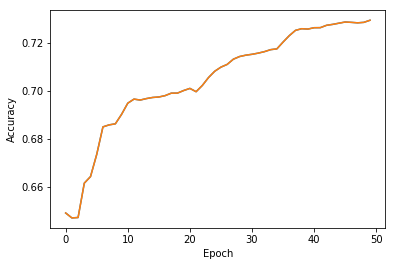

In [8]:
tf.reset_default_graph()
train_neural_network()